In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# Loading Tables from database into dataframe

In [2]:
# Load environment variables from .env file
load_dotenv()

DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')

engine = create_engine(f'postgresql://{DB_USER}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

In [3]:
# Load films table into dataframe
query = "SELECT * FROM films"
df_films = pd.read_sql(query, engine)
df_films.head()

,id,brand,name
0,1,Kodak,Portra 400
1,3,Kodak,Ektar 100
2,4,Kodak,Gold 200
3,6,Kodak,UltraMax 400
4,7,Kodak,Pro Image 100


In [4]:
# Load cameras table into dataframe
query = "SELECT * FROM cameras"
df_cameras = pd.read_sql(query, engine)
df_cameras.head()

,id,manufacturer,model
0,1,Nikon,FM3a
1,2,Canon,AE-1
2,3,Leica,M6
3,4,Pentax,K1000
4,5,Olympus,OM-1


In [5]:
# Load posts table
query = "SELECT * FROM reddit_posts_final"
df_posts = pd.read_sql(query, engine)
df_posts.head()

,title,id,score,upvote_ratio,num_comments,url,author,created_utc,selftext,subreddit,post_hint,text,camera,film,mapped_camera_id,mapped_film_id
0,My analog spacewalk selfie!,17t4nr0,15834,0.97,222,https://i.redd.it/f6cp08d1gszb1.jpg,astro_pettit,2023-11-11 21:40:24,,analog,image,My analog spacewalk selfie!,None,None,NaN,NaN
1,My dad photographed the Mt. St. Helens eruptio...,13smdhy,11386,0.98,263,https://i.redd.it/o0aod1waa82b1.jpg,AndrewAllenReynolds,2023-05-26 19:35:55,,analog,image,My dad photographed the Mt. St. Helens eruptio...,None,Kodak Kodachrome 64,NaN,10.0
2,Nikonos ii/Sea & Sea 12mm/ Acros 100,19ce6qy,9713,0.97,270,https://i.redd.it/h8oteswr1vdc1.jpeg,Mazzolaoil,2024-01-21 21:22:47,,analog,image,Nikonos ii/Sea & Sea 12mm/ Acros 100,Nikonos ii,Acros 100,50.0,15.0
3,Self Portrait Double Exposure on Fuji Instax M...,146mpla,9421,0.96,96,https://i.redd.it/nsybh12c4c5b1.jpg,Xixch_ik,2023-06-11 06:41:22,,analog,image,Self Portrait Double Exposure on Fuji Instax M...,Fuji Instax Mini,Fuji Instax Mini,NaN,NaN
4,Met a girl in a bar who told me she does stick...,18w2q25,7202,0.87,559,https://i.redd.it/p0y8t3ipev9c1.jpeg,film-god,2024-01-01 18:18:43,Yes everything was sterile and clean 😅,analog,image,Met a girl in a bar who told me she does stick...,Leica M7,Kodak Portra 800,41.0,64.0


In [6]:
# Merge reddit_posts_final with films 
merged_df = pd.merge(df_posts, df_films, left_on='mapped_film_id', right_on='id', how='left')

# Group by brand and calculate count and average score
grouped_df = merged_df.groupby('brand').agg(
    post_count=('id_x', 'count'),  
    avg_score=('score', 'mean')    
).reset_index()

grouped_df['avg_score'] = grouped_df['avg_score'].round(2)

# Plots for Film Brands

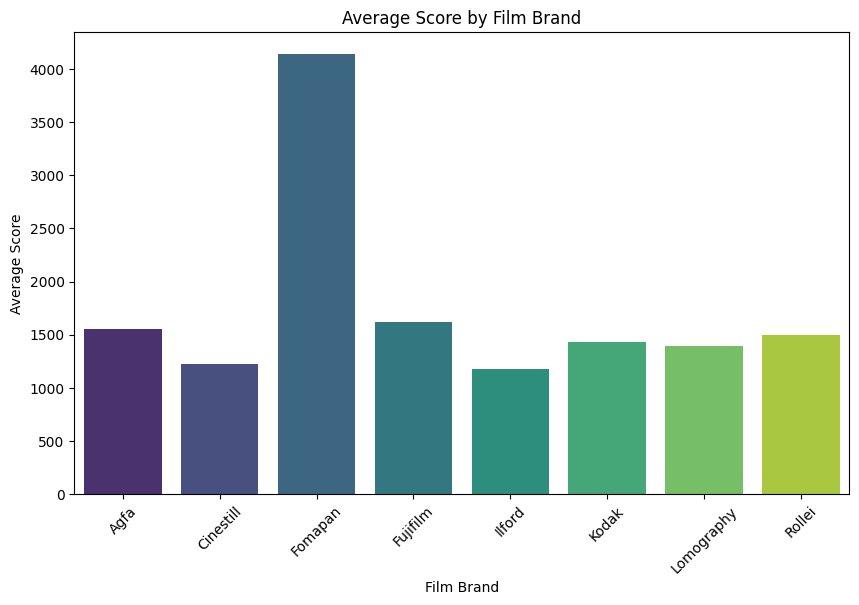

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x='brand', y='avg_score', data=grouped_df, hue='brand', palette='viridis', legend=False)
plt.title('Average Score by Film Brand')
plt.ylabel('Average Score')
plt.xlabel('Film Brand')
plt.xticks(rotation=45)
plt.show()

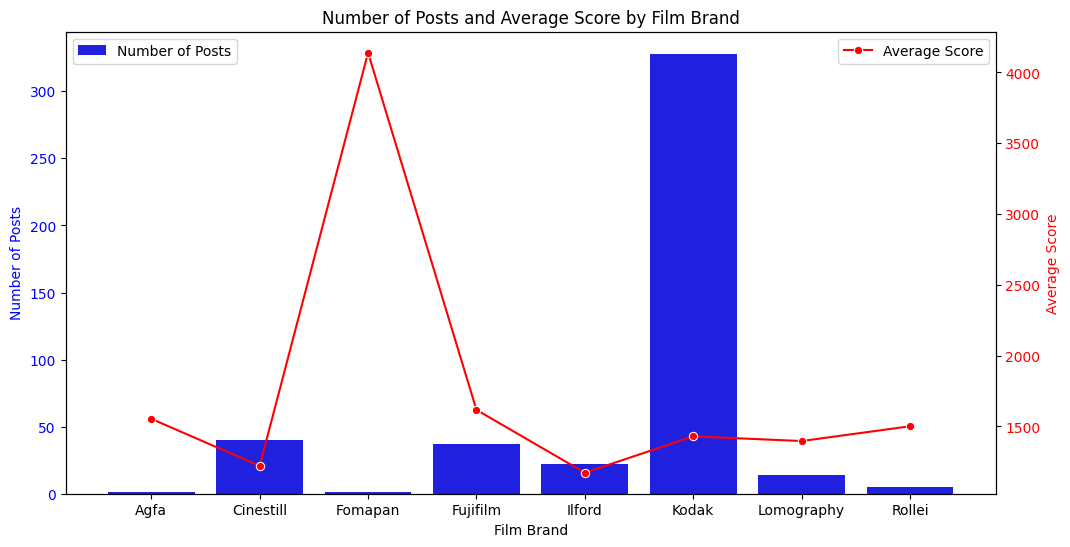

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for post count
sns.barplot(x='brand', y='post_count', data=grouped_df, color='blue', ax=ax1, label='Number of Posts')
ax1.set_xlabel('Film Brand')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Line plot for average score
ax2 = ax1.twinx()
sns.lineplot(x='brand', y='avg_score', data=grouped_df, color='red', marker='o', ax=ax2, label='Average Score')
ax2.set_ylabel('Average Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Number of Posts and Average Score by Film Brand')
plt.show()

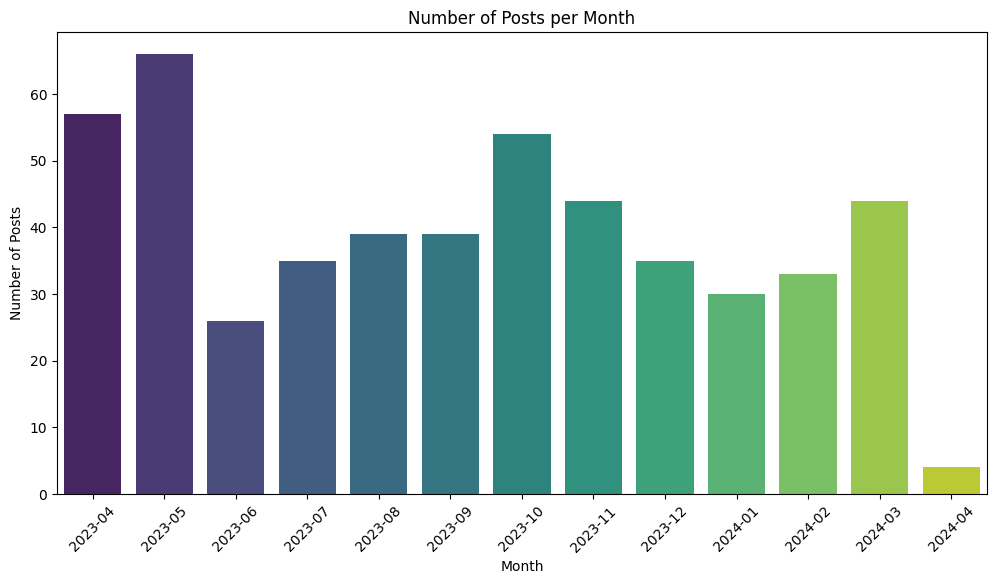

In [9]:
df_posts['created_utc'] = pd.to_datetime(df_posts['created_utc'])
df_posts['year_month'] = df_posts['created_utc'].dt.to_period('M')

monthly_counts = df_posts['year_month'].value_counts().sort_index()
monthly_df = monthly_counts.reset_index()
monthly_df.columns = ['year_month', 'post_count']

plt.figure(figsize=(12, 6))
sns.barplot(x='year_month', y='post_count', data=monthly_df, palette='viridis', hue='year_month', dodge=False)
plt.title('Number of Posts per Month')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

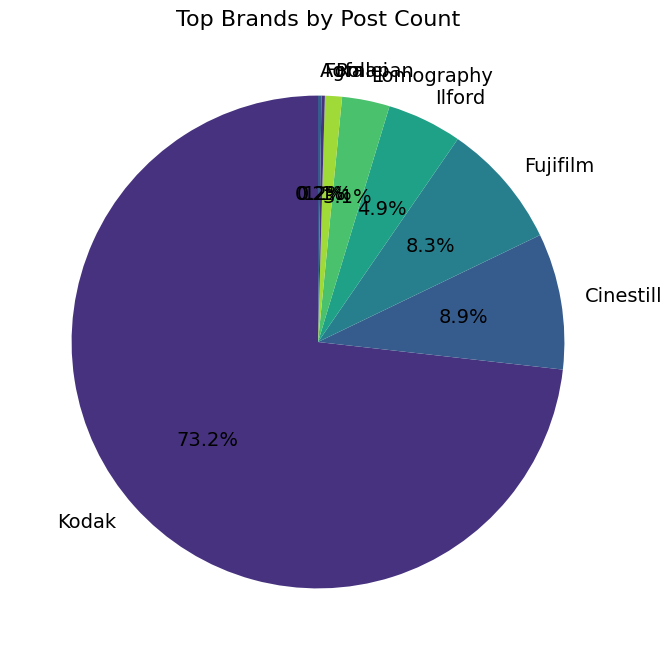

In [10]:
top_brands = merged_df['brand'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    top_brands.values,
    labels=top_brands.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('viridis'),
    textprops={'fontsize': 14}
)
plt.title('Top Brands by Post Count', fontsize=16)
plt.show()

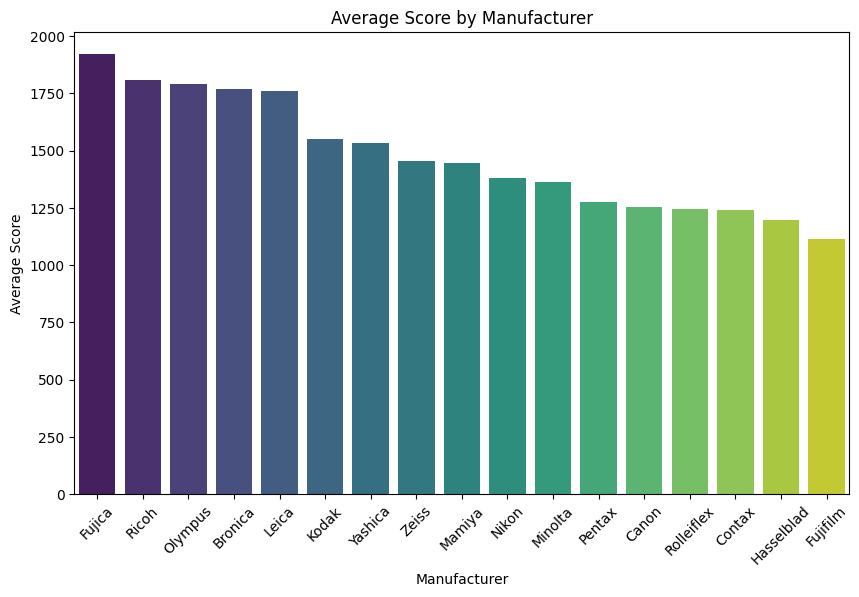

In [11]:
# Merge reddit_posts_final with cameras 
merged_df = pd.merge(df_posts, df_cameras, left_on='mapped_camera_id', right_on='id', how='left')

# Group by manufacturer and calculate post_count and avg_score
grouped_df = merged_df.groupby('manufacturer').agg(
    post_count=('id_x', 'count'),  
    avg_score=('score', 'mean')    
).reset_index()

grouped_df = grouped_df.sort_values(by='avg_score', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='manufacturer', y='avg_score', data=grouped_df, palette='viridis', hue='manufacturer', dodge=False)
plt.title('Average Score by Manufacturer')
plt.ylabel('Average Score')
plt.xlabel('Manufacturer')
plt.xticks(rotation=45)
plt.show()

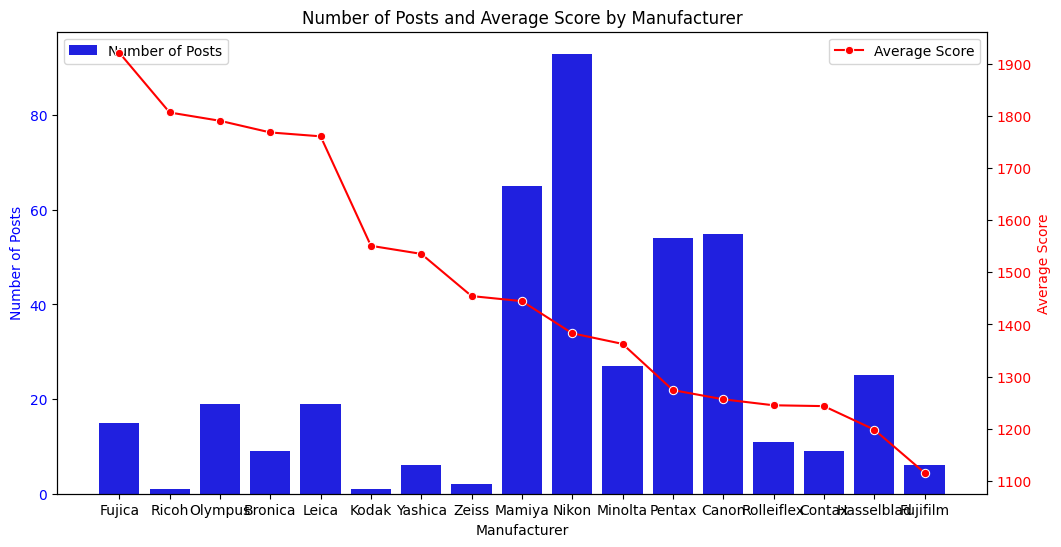

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x='manufacturer', y='post_count', data=grouped_df, color='blue', ax=ax1, label='Number of Posts')
ax1.set_xlabel('Manufacturer')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
sns.lineplot(x='manufacturer', y='avg_score', data=grouped_df, color='red', marker='o', ax=ax2, label='Average Score')
ax2.set_ylabel('Average Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Number of Posts and Average Score by Manufacturer')
plt.show()